# Try out framework with simulated data

In [1]:
import os

import pandas as pd
from IPython.display import display

from q2_ritme.config import (
    HOST_ID,
    MLFLOW_TRACKING_URI,
    SEED_DATA,
    SEED_MODEL,
    TARGET,
    TRAIN_SIZE,
)
from q2_ritme.evaluate_all_experiments import (
    best_trial_name,
    get_all_exp_analyses,
    compare_trials,
)
from q2_ritme.evaluate_models import (
    aggregate_best_models_metrics_and_configs,
    get_predictions,
    plot_best_models_comparison,
    plot_model_training_over_iterations,
    plot_rmse_over_experiments,
    plot_rmse_over_time,
    retrieve_best_models,
)
from q2_ritme.process_data import load_n_split_data
from q2_ritme.tune_models import run_all_trials

# 30.437 is avg. number of days per month
DAYS_PER_MONTH = 30.437
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
ls_model_types = ["nn", "xgb", "linreg", "rf"]
experiment_tag = "test_synthetic"

## Load and split data

In [3]:
train_val, test = load_n_split_data(None, None, HOST_ID, TARGET, TRAIN_SIZE, SEED_DATA)

Train: (75, 22), Test: (25, 22)


## Run all experiments

In [4]:
comparison_output = os.path.join("best_models", experiment_tag)

if os.path.exists(comparison_output):
    raise ValueError(
        f"This experiment tag already exists: {experiment_tag}. Please use another one."
    )

In [5]:
result_dic = run_all_trials(
    train_val,
    TARGET,
    HOST_ID,
    SEED_DATA,
    SEED_MODEL,
    MLFLOW_TRACKING_URI,
    experiment_tag,
    model_types=ls_model_types,
    fully_reproducible=False,
)

(train_rf pid=16510) Train: (48, 21), Test: (27, 21) [repeated 4x across cluster]


2024-03-02 18:30:00,844	INFO tune.py:1148 -- Total run time: 11.85 seconds (11.81 seconds for the tuning loop).


## Evaluate best models: train_val vs. test - performance

<Figure size 2560x1920 with 0 Axes>

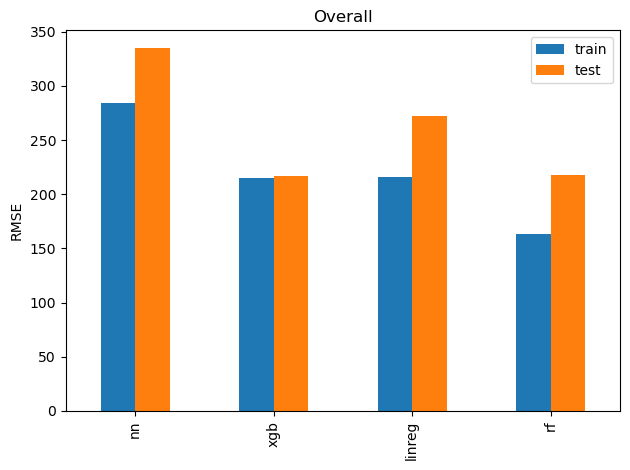

In [6]:
best_model_dic = retrieve_best_models(result_dic)

# Assuming best_model_dic and the datasets are available
non_features = [TARGET, HOST_ID]
features = [x for x in train_val if x not in non_features]

preds_dic = {}
for model_type, tmodel in best_model_dic.items():
    train_pred = get_predictions(train_val, tmodel, TARGET, features, "train")
    test_pred = get_predictions(test, tmodel, TARGET, features, "test")
    all_pred = pd.concat([train_pred, test_pred])

    # save all predictions to model file
    path2save = os.path.join(tmodel.path, "predictions.csv")
    all_pred.to_csv(path2save, index=True)
    preds_dic[model_type] = all_pred

plot_rmse_over_experiments(preds_dic, comparison_output)

<Figure size 1920x1440 with 0 Axes>

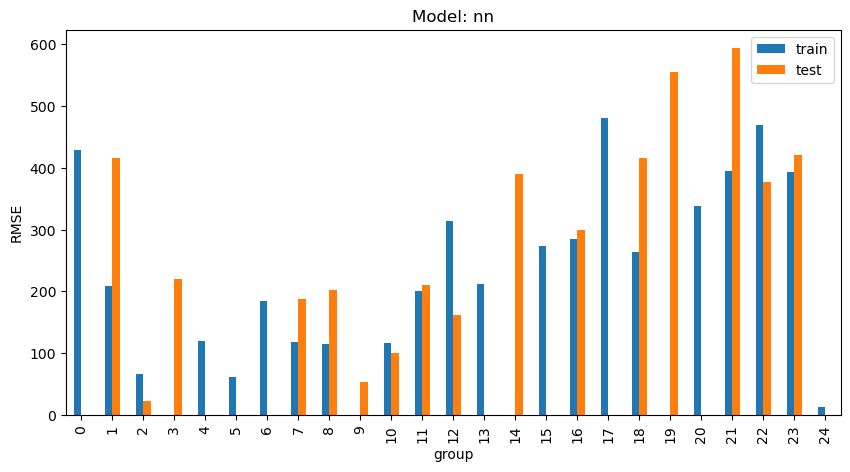

In [7]:
plot_rmse_over_time(preds_dic, ls_model_types, DAYS_PER_MONTH, comparison_output)

## Evaluate best models: train vs. val - performance and config

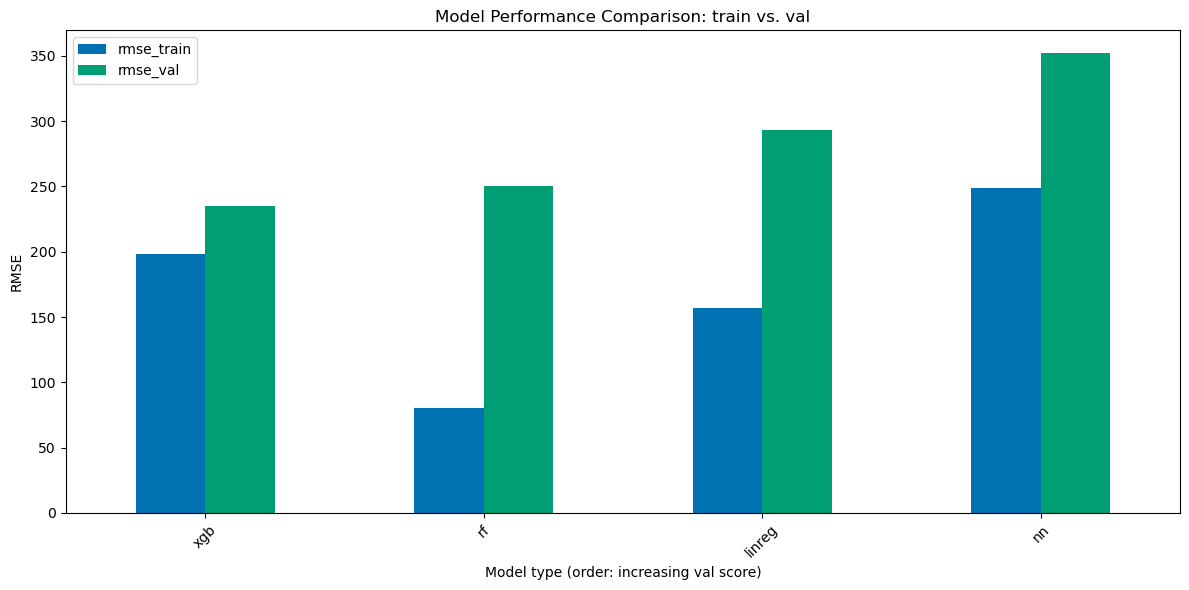

,nn,xgb,linreg,rf
data_transform,alr,alr,None,alr
data_alr_denom_idx,1,2,11,3
n_hidden_layers,12,NaN,NaN,NaN
learning_rate,0.006464,NaN,NaN,NaN
batch_size,32,NaN,NaN,NaN
epochs,50,NaN,NaN,NaN
n_units_hl0,46,NaN,NaN,NaN
n_units_hl1,47,NaN,NaN,NaN
n_units_hl2,40,NaN,NaN,NaN
n_units_hl3,14,NaN,NaN,NaN


In [8]:
metrics_all, best_configs = aggregate_best_models_metrics_and_configs(result_dic)

plot_best_models_comparison(metrics_all, comparison_output)
display(best_configs)

## Evaluate one model over iterations

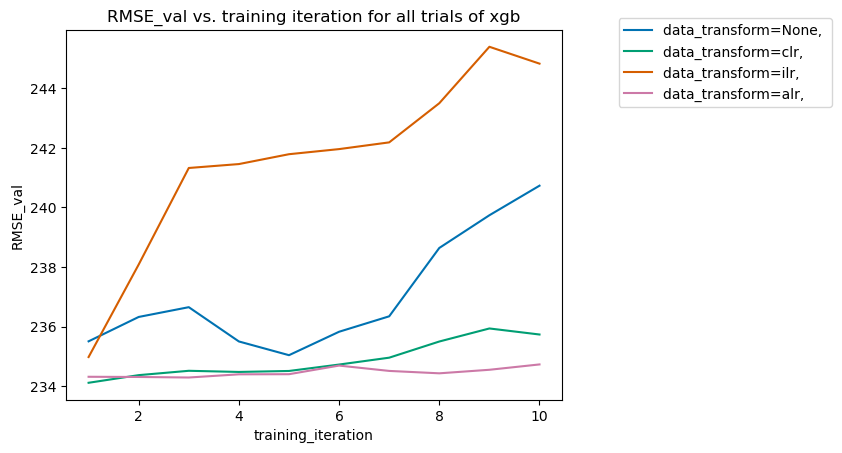

In [9]:
plot_model_training_over_iterations("xgb", result_dic, labels=["data_transform"])

## Postrun evaluation over all experiments performed
experiment > trial

In [10]:
path_overall_comparison = os.path.join("best_models", "compare_all")

2024-03-02 18:30:06,444	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2024-03-02 18:30:06,478	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2024-03-02 18:30:06,579	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is pe

<Figure size 2560x1920 with 0 Axes>

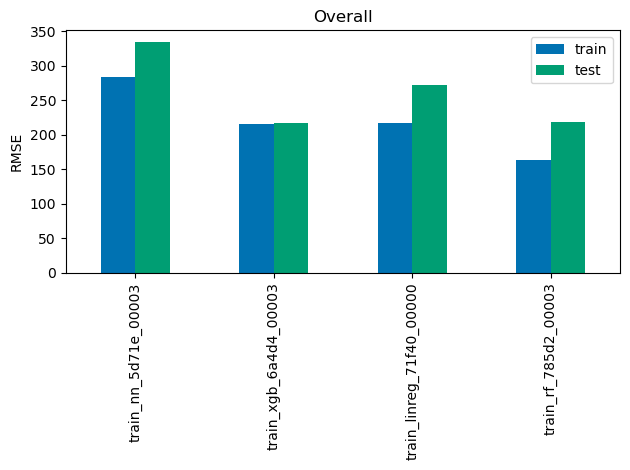

In [11]:
# find best trial over all experiments for each model type
best_trials_overall = {}
for model in ls_model_types:
    # read all ExperimentAnalysis objects from this directory
    experiment_dir = f"best_models/*/{model}"
    analyses_ls = get_all_exp_analyses(experiment_dir)

    # identify best trial from all analyses of this model type
    best_trials_overall[model] = best_trial_name(analyses_ls, "rmse_val", mode="min")

compare_trials(best_trials_overall, path_overall_comparison)